In [2]:
from __future__ import print_function
import itertools
import pandas as pd
import numpy as np
import os
import logging
import glob
import networkx as nx
import math
from tqdm import tqdm

/Users/rajeevkumar/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
sampdirs = glob.glob('../../sailfish_quant/*')
auxDir = "aux"
cutoff = 0.5
netfile = 'netfile'
# output = rapObj.buildNetFile(sampdirs, netfile, cutoff, auxDir, False)
ofile ='filterGraph_svm.txt'
expDict = {
    'scramble': {'SRR493366_quant': '../../sailfish_quant/SRR493366_quant',
                 'SRR493367_quant': '../../sailfish_quant/SRR493367_quant',
                 'SRR493368_quant': '../../sailfish_quant/SRR493368_quant'},
    'HOXA1KD': {'SRR493369_quant': '../../sailfish_quant/SRR493369_quant',
                'SRR493370_quant': '../../sailfish_quant/SRR493370_quant',
                'SRR493371_quant': '../../sailfish_quant/SRR493371_quant'}
}

In [4]:
class EquivCollection(object):
    def __init__(self):
        self.tnames = []
        self.eqClasses = {}
        self.hasNames = False

    def setNames(self, names):
        self.tnames = names
        self.hasNames = True

    def add(self, tids, count):
        if tids in self.eqClasses:
            self.eqClasses[tids] += count
        else:
            self.eqClasses[tids] = count


In [5]:
def readEqClass(eqfile, eqCollection):
    with open(eqfile) as ifile:
        numTran = int(ifile.readline().rstrip())
        numEq = int(ifile.readline().rstrip())
        print("\nfile: {}; # tran = {}; # eq = {}".format(eqfile, numTran, numEq))
        if not eqCollection.hasNames:
            tnames = []
            for i in range(numTran):
                tnames.append(ifile.readline().rstrip())
            eqCollection.setNames(tnames)
        else:
            for i in range(numTran):
                ifile.readline()

        for i in range(numEq):
            toks = list(map(int, ifile.readline().rstrip().split('\t')))
            nt = toks[0]
            tids = tuple(toks[1:-1])
            count = toks[-1]
            eqCollection.add(tids, count)


In [6]:
def getCountsFromEquiv(eqCollection):
        countDict = {}
        tn = eqCollection.tnames
        for tids, count in eqCollection.eqClasses.items():
            for t in tids:
                if tn[t] in countDict:
                    countDict[tn[t]] += count
                else:
                    countDict[tn[t]] = count
        # ensure no division by 0
        for t in eqCollection.tnames:
            if t in countDict:
                countDict[t] += 1.0
            else:
                countDict[t] = 1.0
        return countDict

In [7]:
# Get just the set of condition names
conditions = expDict.keys()
logging.info("conditions = {}".format(conditions))
eqClasses = {}
for cond in conditions:
    print(expDict[cond])
    for sampNum, sampPath in expDict[cond].items():
        if cond not in eqClasses:
            eqClasses[cond] = EquivCollection()
        eqPath = os.path.sep.join([sampPath, auxDir, "eq_classes.txt"])
        readEqClass(eqPath, eqClasses[cond])

{'SRR493367_quant': '../../sailfish_quant/SRR493367_quant', 'SRR493368_quant': '../../sailfish_quant/SRR493368_quant', 'SRR493366_quant': '../../sailfish_quant/SRR493366_quant'}

file: ../../sailfish_quant/SRR493367_quant/aux/eq_classes.txt; # tran = 107389; # eq = 98035

file: ../../sailfish_quant/SRR493368_quant/aux/eq_classes.txt; # tran = 107389; # eq = 101801

file: ../../sailfish_quant/SRR493366_quant/aux/eq_classes.txt; # tran = 107389; # eq = 95472
{'SRR493371_quant': '../../sailfish_quant/SRR493371_quant', 'SRR493369_quant': '../../sailfish_quant/SRR493369_quant', 'SRR493370_quant': '../../sailfish_quant/SRR493370_quant'}

file: ../../sailfish_quant/SRR493371_quant/aux/eq_classes.txt; # tran = 107389; # eq = 104868

file: ../../sailfish_quant/SRR493369_quant/aux/eq_classes.txt; # tran = 107389; # eq = 100141

file: ../../sailfish_quant/SRR493370_quant/aux/eq_classes.txt; # tran = 107389; # eq = 102891


In [8]:
sep = os.path.sep
sffiles = [sep.join([sd, 'quant.sf']) for sd in sampdirs]
eqfiles = [sep.join([sd, auxDir, 'eq_classes.txt']) for sd in sampdirs]

In [13]:
def process_data(eqClass_counter, eqfile, numSamp, firstSamp, tnames, dict_eqClass, dic_uniq_transcripts):
    print('Entered function')
    with open(eqfile) as ifile:
        numSamp += 1
        numTran = int(ifile.readline().rstrip())
        numEq = int(ifile.readline().rstrip())
        if firstSamp:
            for i in range(numTran):
                tnames.append(ifile.readline().rstrip())
        else:
            for i in range(numTran):
                ifile.readline()
        for i in range(numEq): #numEq
            eqClass_counter += 1
            toks = list(map(int, ifile.readline().rstrip().split('\t')))
            tids = tuple(toks[1:-1])
            readCount = toks[-1]
            if tids not in dict_eqClass:
                dict_eqClass[tids] = eqClass_counter    #eqClass_counter
            for ids in tids:
                if ids not in dic_uniq_transcripts:
                    set_tup = set()
                    set_tup.add(eqClass_counter)
                    dic_uniq_transcripts[ids] = set_tup
                else:
                    set_tup = dic_uniq_transcripts[ids]
                    set_tup.add(eqClass_counter)
                    dic_uniq_transcripts[ids] = set_tup

In [14]:
cond = ['scramble', 'HOXA1KD']
conditions_data = []
condition1_data = None
condition2_data = None
for cond_val in cond:
    condition1_paths = expDict[cond_val].values()
    dict_eqClass = {}
    dic_uniq_transcripts = {}
    eqClass_counter = 0
    for path in condition1_paths:
        tnames = []
        firstSamp = True
        numSamp = 0
        eqfile = os.path.sep.join([path, auxDir, "eq_classes.txt"])
        print(eqfile)
        process_data(eqClass_counter, eqfile, numSamp, firstSamp, tnames, dict_eqClass, dic_uniq_transcripts)
    
    lst_uniq_tids = dic_uniq_transcripts.keys()
    dict_prob = {}
    lst_keys = dict_eqClass.keys()
    flag = True
    for tup in lst_keys:
        for t1,t2 in itertools.combinations(tup,2):  
            readCount_t1 = 0
            readCount_t2 = 0
            readCount_t1t2 = 0
            set_t1 = dic_uniq_transcripts[t1]
            set_t2 = dic_uniq_transcripts[t2]
            length_intersection = len(set_t1.intersection(set_t2))
            length_union = len(set_t1.union(set_t2))
            if length_intersection > 0:
                dict_prob[(t1,t2)] = (length_intersection / len(set_t1), length_intersection / len(set_t2))
    
    conditions_data.append(dict_prob)

condition1_data = conditions_data[0]
condition2_data = conditions_data[1]

../../sailfish_quant/SRR493367_quant/aux/eq_classes.txt
Entered function
../../sailfish_quant/SRR493368_quant/aux/eq_classes.txt
Entered function
../../sailfish_quant/SRR493366_quant/aux/eq_classes.txt
Entered function
../../sailfish_quant/SRR493371_quant/aux/eq_classes.txt
Entered function
../../sailfish_quant/SRR493369_quant/aux/eq_classes.txt
Entered function
../../sailfish_quant/SRR493370_quant/aux/eq_classes.txt
Entered function


In [21]:
probSuccess_diff  = {}
for k,cond1_val in condition1_data.items():
    if k in condition2_data:
        cond2_val = condition2_data[k]
        ratio_1 = cond1_val[0]/cond2_val[1]
        ratio_2 = cond2_val[0]/cond2_val[1]
        diff = abs(ratio_1 - ratio_2)
        probSuccess_diff[k] = diff

In [24]:
new_probSuccess = {}
with open('ver2_output_clusterCount3.txt', 'w') as ofile:
    for k,v in probSuccess_diff.items():
        if v < 0.2 :   
            t1_name = tnames[k[0]]
            t2_name = tnames[k[1]]
            new_probSuccess[(t1_name, t2_name)] = v
            ofile.write("{}\t{}\t{}\n".format(t1_name, t2_name, v))
print(len(new_probSuccess))

116218


In [23]:
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [90]:
result_table = pd.DataFrame()
model1 = [0.9767, 0.07666, 0.142170]
model2 = [0.9769021, 0.0762835, 0.14151]
model3 = [0.97820, 0.08015, 0.14817]
model4 = [0.9802699, 0.066665, 0.124840]
# result_table = pd.DataFrame({'Model 1': model1, 'Model 2': model2, 'Model 3': model3, 'Model 4': model4})
# values = [0.9767, 0.07666, 0.142170, 0.9769021, 0.0762835, 0.14151, 0.97820, 0.08015, 0.14817, 0.9802699, 0.066665, 0.124840]

# values = [0.9777, 0.08828, 0.161945, 0.9715173, 0.0731545, 0.13606, 0.97771, 0.08392, 0.15458, 0.9786245, 0.065386,0.12258]
values = [0.978, 0.07867, 0.14563, 0.9787939, 0.0784275, 0.14521, 0.97902, 0.07812, 0.14470, 0.97930524, 0.0694378, 0.1296807]
modelType = ['Model 1', 'Model 1', 'Model 1', 'Model 2', 'Model 2', 'Model 2', 
             'Model 3', 'Model 3', 'Model 3', 'Model 4', 'Model 4', 'Model 4']
resultCategory = ['Precision', 'Recall', 'F-1','Precision', 'Recall', 'F-1', 'Precision', 
                  'Recall', 'F-1', 'Precision', 'Recall', 'F-1']
result_table = pd.DataFrame({'Data': values, 'Model Type': modelType, 'Result Category': resultCategory})

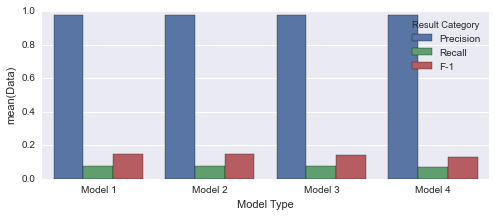

In [91]:
plt.figure(figsize=(8, 3))
sb.barplot(data=result_table, x='Model Type', y='Data', hue='Result Category')

In [58]:
sns.barplot(x="day", y="total_bill", data=tips)

,Data,Model Type,Result Category
0,0.976700,Model 1,Precision
1,0.076660,Model 1,Recall
2,0.142170,Model 1,F-1
3,0.976902,Model 2,Precision
4,0.076284,Model 2,Recall
5,0.141510,Model 2,F-1
6,0.978200,Model 3,Precision
7,0.080150,Model 3,Recall
8,0.148170,Model 3,F-1
9,0.980270,Model 4,Precision
